In [2]:
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")

In [3]:
tf.__version__

'2.16.1'

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(train_df.shape)
print(test_df.shape)

print(train_df.head())
print(test_df.head())

(42000, 785)
(28000, 784)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0   

In [5]:
Y_train = train_df["label"]
X_train = train_df.drop(labels = ["label"], axis = 1)

Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [6]:
fig = px.histogram(Y_train, x="label", title="Frequency of Each Label", labels={"label": "Digit"}, color="label")
fig.update_layout(bargap=0.1, plot_bgcolor='rgb(250, 250, 250)',)
fig.update_xaxes(tickvals=list(range(10)), ticktext=[str(i) for i in range(10)])
fig.show()

In [7]:
#data normalization between 0 and 1 - data is in RGB, hence 0-255
X_train = X_train / 255.0
X_test = test_df / 255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px)
X_train_img = X_train.values.reshape(-1,28,28,1)
X_test_img = X_test.values.reshape(-1,28,28,1)

In [9]:
# example of a single image
fig = px.imshow(X_train_img[10][:,:,0])
fig.show()

In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train_img = to_categorical(Y_train, num_classes = 10)

In [11]:
# split training and validation set as test dataset is not labeled
X_train_img, X_val_img, Y_train_img, Y_val_img = train_test_split(X_train_img, Y_train_img, test_size = 0.2, random_state=10)

#### Convolutional Neural Network - CNN

In [12]:
cnn = tf.keras.models.Sequential()
# add Dropout?

cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(256, activation = "relu"))
cnn.add(tf.keras.layers.Dense(10, activation = "softmax"))

In [13]:
cnn.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Learning Rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
# data augmentation to prevent overfitting (various options tested)
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,  # slightly rotate images
        zoom_range = 0.1, # slightly zoom image
        width_shift_range=0.1,  # slightly shift images horizontally
        height_shift_range=0.1,  # slightly shift images vertically
        horizontal_flip=False,  # don't randomly flip images - not for digits
        vertical_flip=False)  # don't randomly flip images - not for digits

In [16]:
image_generator.fit(X_train_img)

In [17]:
# Fit the model
trained_model = cnn.fit(image_generator.flow(X_train_img,Y_train_img, batch_size=86),
                              epochs = 1, validation_data = (X_val_img,Y_val_img),
                              verbose = 2, steps_per_epoch=X_train.shape[0],
                              callbacks=[learning_rate_reduction])

42000/42000 - 23s - 537us/step - accuracy: 0.9085 - loss: 0.2849 - val_accuracy: 0.9795 - val_loss: 0.0649 - learning_rate: 0.0010


#### Training evaluation using validation set

In [18]:
Y_pred = cnn.predict(X_val_img)
Y_pred_cls = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val_img,axis = 1) 

confusion_matrix = confusion_matrix(Y_true, Y_pred_cls) 

print(confusion_matrix)

263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
[[783   1   0   0   0   0   4   2   5   1]
 [  0 930   0   0   5   0   1   2   8   0]
 [  0   6 820   8   1   0   0  17   4   0]
 [  0   0   0 849   0   3   0   3   1   0]
 [  1   0   1   0 819   0   5   0   0   0]
 [  0   0   1   3   0 765   3   0   1   0]
 [  0   1   0   0   0   1 783   0   2   0]
 [  0   0   1   0   2   0   0 866   0   0]
 [  0   5   0   4   1   3   4   3 812   4]
 [  2   0   0   4  18   2   0  24   4 801]]


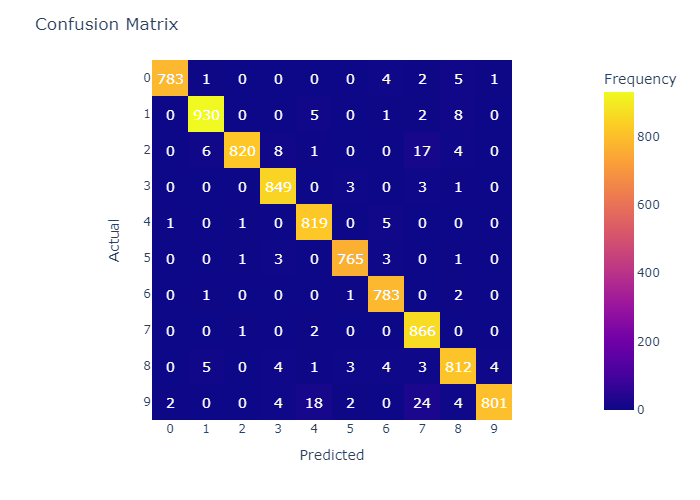

In [20]:
#draw confusion matrix
fig = px.imshow(confusion_matrix,
                labels=dict(x="Predicted", y="Actual", color="Frequency"),
                x=[str(i) for i in range(10)],
                y=[str(i) for i in range(10)])

fig.update_layout(title="Confusion Matrix")

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        fig.add_annotation(dict(font=dict(color="white",size=14),
                                x=j,
                                y=i,
                                showarrow=False,
                                text=str(confusion_matrix[i][j]),
                                textangle=0,
                                xanchor="center",
                                yanchor="middle"))

fig.show(renderer="png")

#### Predict test images

In [21]:
Y_pred_test = cnn.predict(X_test_img)
Y_pred_cls = np.argmax(Y_pred_test,axis = 1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


#### Visualisation of predictions of the test dataset

In [26]:
show_test_values = 5

fig = make_subplots(rows=show_test_values, 
                    cols=2, 
                    specs=[[{"type": "image"},{"type": "indicator"}]]*show_test_values,
                    column_widths=[0.5, 0.5],
                    row_heights=[0.1]*show_test_values,
                    vertical_spacing=0.1,
                    horizontal_spacing=0.1,
                    column_titles=["Test image", "CNN prediction"]
                    )

for i in range(show_test_values):
    random_test_number = random.randint(0, len(X_test_img))
    # Add image in column 1
    img_fig = px.imshow(X_test_img[random_test_number][:,:,0], width=800,height=800)
    fig.add_trace(img_fig.data[0], row=i+1, col=1)    
    # Add predicted class in column 2
    fig.add_trace(go.Indicator(mode="number", value=Y_pred_cls[random_test_number]), row=i+1, col=2)

fig.update_layout(width=400)
fig.update_layout(height=200*show_test_values)
fig.update(layout_coloraxis_showscale=False)
fig.show()